## NYC Taxi Fare Prediction ##

### Part 1: Import and Set Data ###

In [18]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import visuals as vs
from math import sin, cos, sqrt, atan2, radians,asin
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
from taxi_functions import distance, boundaryBox, isLocation

% matplotlib inline
plt.style.use('seaborn-whitegrid')

We will start by uploading a portion of the train dataset to explore. The full dataset consists of ~55M samples. We will begin with 3M. 

In [4]:
# Read training data into pandas dataframe

df_train = pd.read_csv('all/train.csv', nrows = 3000000, parse_dates=["pickup_datetime"])

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [16]:
# list first few rows
display(df_train.head(n=5))

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,log_fare_amount
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,17,Monday,6,2009,1.504077
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,16,Tuesday,1,2010,2.827314
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,0,Thursday,8,2011,1.740466
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,4,Saturday,4,2012,2.041220
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,7,Tuesday,3,2010,1.667707


Let's examine what datatypes we'll be working with:

In [5]:
df_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

What are the ranges of values for each of our feature spaces?

In [6]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,3.000000e+06,3.000000e+06,3.000000e+06,2.999977e+06,2.999977e+06,3.000000e+06
mean,1.134246e+01,-7.250894e+01,3.992033e+01,-7.250740e+01,3.991728e+01,1.684528e+00
std,9.828907e+00,1.320223e+01,8.644440e+00,1.308827e+01,9.984419e+00,1.329084e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.408430e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


A few observations from the data description:

* The minimum of the ```fare_amount``` feature is negative. As this is not realistic, I will drop those samples from the dataset.
* Some of the longitude/latitude coordinates are way off. We'll make a bounding box later and drop those as well.

## Visualizing Data ##

In [28]:
# Map boundary boxes
BB= {
    'min_lng':-74.22,
    'min_lat':40.55,
    'max_lng':-73.65,
    'max_lat':41
}

BB_zoom = {
    'min_lng':-74.1,
    'min_lat':40.6,
    'max_lng':-73.7,
    'max_lat':40.9
}

BB_zoom_2 = {
    'min_lng':-74,
    'min_lat':40.7,
    'max_lng':-73.95,
    'max_lat':40.8
}

In [32]:
# Using small datapoints, the streetgrid of New York becomes visible
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b'), s = 0.005, alpha = 0.5):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = boundary_box(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=s, alpha=alpha)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=s, alpha=alpha)
    
# Eliminate samples with latitude/longitude coordinates outside NYC boundary
def boundary_box(df, BB):
    return (df.pickup_longitude >= BB['min_lng']) & (df.pickup_longitude <= BB['max_lng']) & \
           (df.pickup_latitude >= BB['min_lat']) & (df.pickup_latitude <= BB['max_lat']) & \
           (df.dropoff_longitude >= BB['min_lng']) & (df.dropoff_longitude <= BB['max_lng']) & \
           (df.dropoff_latitude >= BB['min_lat']) & (df.dropoff_latitude <= BB['max_lat'])

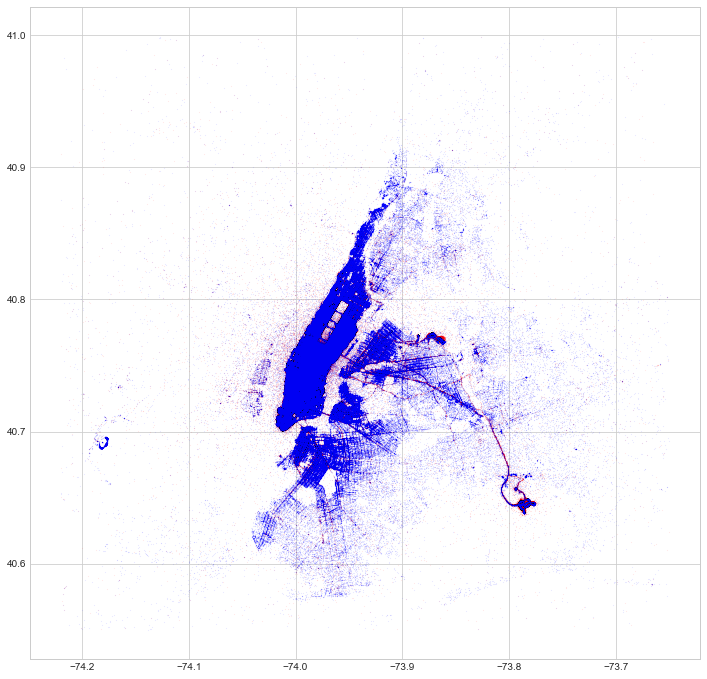

In [33]:
# Plot zoomed out
plot_hires(df_train, BB, s = 0.01, alpha = 0.3)

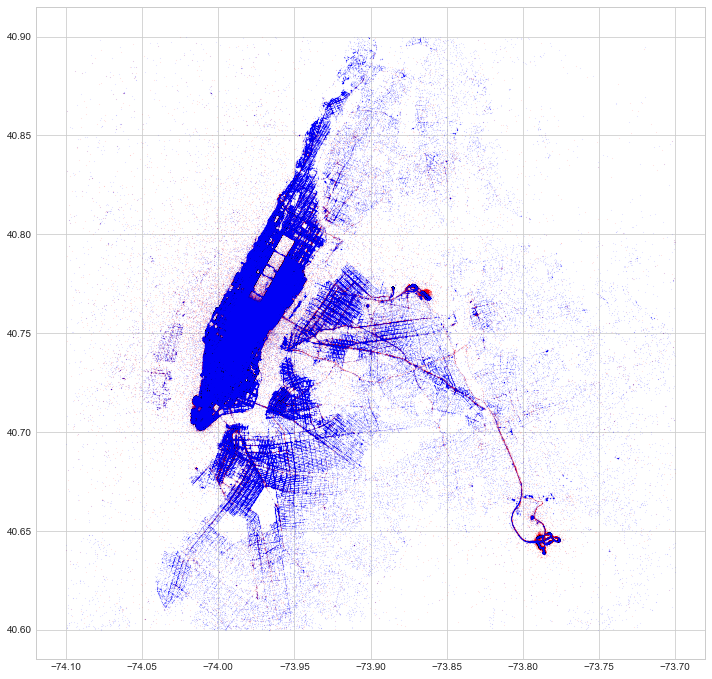

In [35]:
# First level zoom
plot_hires(df_train, BB_zoom)

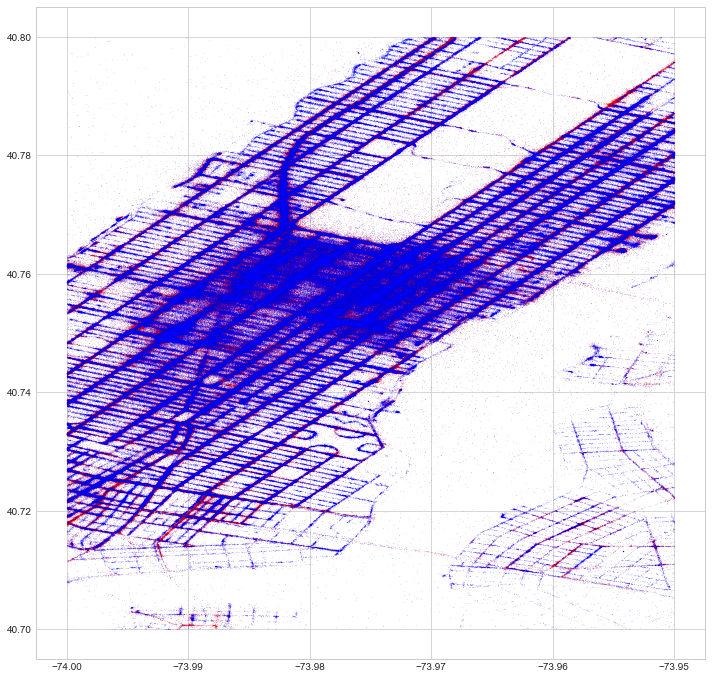

In [36]:
# Street-level zoom
plot_hires(df_train, BB_zoom_2)

## Feature Generation / Data Exploration ##

Several features to add:
    * convert datetime to year, day, hour, etc.
    * add distance feature
    * add is_airport feature

### Datetime features: Break into year, day, hour features, etc. ###

In [37]:
# Convert pickup_datetime to a DateTime object
df_train.pickup_datetime=pd.to_datetime(df_train.pickup_datetime,format='%Y-%m-%d %H:%M:%S UTC')

In [38]:
# Create datetime features based on pickup_datetime
df_train['pickup_date'] = df_train.pickup_datetime.dt.date
df_train['pickup_day'] = df_train.pickup_datetime.apply(lambda x:x.day)
df_train['pickup_hour'] = df_train.pickup_datetime.apply(lambda x:x.hour)
df_train['pickup_day_of_week'] = df_train.pickup_datetime.apply(lambda x:calendar.day_name[x.weekday()])
df_train['pickup_month'] = df_train.pickup_datetime.apply(lambda x:x.month)
df_train['pickup_year'] = df_train.pickup_datetime.apply(lambda x:x.year)

Check for missing values

In [39]:
df_train[pd.isnull(df_train)].sum()

key                   0.0
fare_amount           0.0
pickup_datetime       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
passenger_count       0.0
pickup_date           0.0
pickup_day            0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_month          0.0
pickup_year           0.0
log_fare_amount       0.0
trip_distance         0.0
dtype: float64

### Distance: Use lat-lng to get distance ###

In [40]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

In [41]:
# add new column to dataframe with distance in miles
df_train['trip_distance'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)

### Airport Features ###

Airport taxi rides in New York City are fixed-rate. I will create features to label rides
as to/from one of New York's three major airports (JFK, EWR, LGA) or not, using lat/lng
coordinates.

In [43]:
# Coordinates for NYC Airports
# Source: https://www.coordinatesfinder.com/

nyc_airports = {
    # JFK Airport Coordinates
    'JFK':{
        'lat':40.6413111,
        'lng':-73.7781391
    },
    # Newark Liberty Airport Coordinates
    'EWR':{
        'lat':40.6895314,
        'lng':-74.1744624
    },
    # LaGuardia Airport Coordinates
    'LGA':{
        'lat':40.7769271,
        'lng':-73.8739659
    }
}

In [107]:
# Radius for airport trip classification
range = 1
# Trips to/from JFK
df_train['to_from_JFK'] = (distance(df_train.pickup_latitude,
                       df_train.pickup_longitude,
                       nyc_airports['JFK']['lat'],
                       nyc_airports['JFK']['lng']) < range)

# Trips to/from EWR
df_train['to_from_EWR'] = (distance(df_train.pickup_latitude,
                       df_train.pickup_longitude,
                       nyc_airports['EWR']['lat'],
                       nyc_airports['EWR']['lng']) < range)

# Trips to/from LGA
df_train['to_from_LGA'] = (distance(df_train.pickup_latitude,
                       df_train.pickup_longitude,
                       nyc_airports['LGA']['lat'],
                       nyc_airports['LGA']['lng']) < range)

In [108]:
df_train['to_from_airport'] = (df_train.to_from_EWR | 
                               df_train.to_from_JFK | 
                               df_train.to_from_LGA)

In [109]:
df_train.to_from_airport.describe()

count     2999800
unique          2
top         False
freq      2896958
Name: to_from_airport, dtype: object

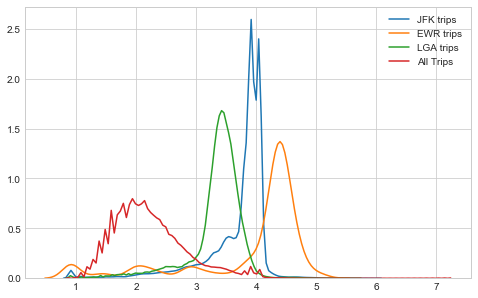

In [204]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_train[df_train.to_from_JFK == 1]['log_fare_amount'], label = 'JFK trips')
sns.kdeplot(df_train[df_train.to_from_EWR == 1]['log_fare_amount'], label = 'EWR trips')
sns.kdeplot(df_train[df_train.to_from_LGA == 1]['log_fare_amount'], label = 'LGA trips')
sns.kdeplot(df_train.log_fare_amount, label = 'All Trips')

Intuition is correct: airport trips have much higher ```fare_amount``` values.

## Part 2: Data Exploration, Cleaning ##

#### Distribution of ```fare_amount``` ####

Text(0.5,1,'Distribution of fare_amount')

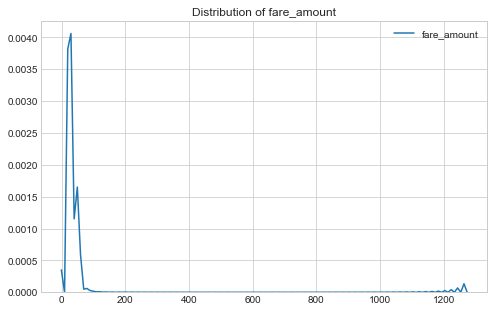

In [110]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_train['fare_amount']).set_title("Distribution of fare_amount")

Text(0.5,1,'Distribution of passenger_count')

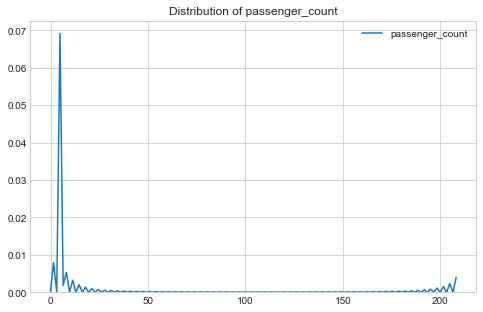

In [111]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_train.passenger_count).set_title("Distribution of passenger_count")

Observations:
    * There are negative values in the data
    * Data is also skewed

In [112]:
df_train.loc[df_train['fare_amount']<=0].shape

(0, 20)

There are 200 records with negative ```fare_amount```. We remove these records from the data.

In [113]:
df_train = df_train.loc[df_train['fare_amount']>0]
df_train.shape

(2999800, 20)

From the NYC taxi and limousine commission: http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

The initial charge is $2.50.
Plus 50 cents per 1/5 mile or 50 cents per 60 seconds in slow traffic or when the vehicle is stopped.
In moving traffic on Manhattan streets, the meter should “click” approximately every four downtown blocks, or one block going cross-town (East-West).
There is a 50-cent MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
There is a 30-cent Improvement Surcharge. 
There is a daily 50-cent surcharge from 8pm to 6am.

Since the initial charge for every taxi ride in New York is 2.50 since 2012 (and 2.00 since earlier than our dataset starts recording), let's see how many samples have a fare at or below the $2.00 boundary.

In [177]:
train[(df_train.fare_amount <= 2.00) | ((df_train.fare_amount <= 2.50) & (df_train.pickup_year >= 2012))].shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(1527, 22)

There are 1527 samples where the fare was either below 2.00, or below 2.50 and in the year 2012 or later. We will remove these samples.

In [178]:
df_train = df_train[(df_train.fare_amount > 2.5) | ((df_train.fare_amount > 2.0) & (df_train.pickup_year < 2012))]

In [179]:
df_train.shape

(2993458, 20)

Since the ```fare_amount``` data is skewed, let us take the log transformation of the fare amount and plot the new distribution.

In [114]:
df_train['log_fare_amount'] = np.log(df_train.fare_amount)

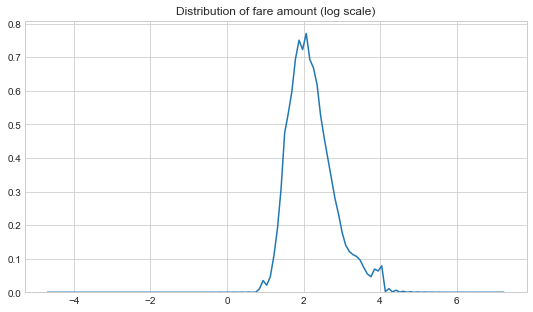

In [115]:
plt.figure(figsize=(9,5))
sns.kdeplot(df_train['log_fare_amount'].values).set_title("Distribution of fare amount (log scale)");

### Eliminating Outliers from on lat/lng coordinates ###

Let's read the test data and see what our boundaries are. 

In [117]:
df_test = pd.read_csv('./all/test.csv')
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


#### Range of lat/lng in training set ####

In [118]:
# Range of pickup latitude
print("Range of pickup latitude: ", min(df_train.pickup_latitude), max(df_train.pickup_latitude))

# Range of dropoff latitude
print("Range of dropoff latitude: ", min(df_train.dropoff_latitude), max(df_train.dropoff_latitude))

# Range of pickup longitude
print("Range of pickup longitude: ", min(df_train.pickup_longitude), max(df_train.pickup_longitude))

# Range of dropoff longitude
print("Range of dropoff longitude: ", min(df_train.dropoff_longitude), max(df_train.dropoff_longitude))

Range of pickup latitude:  -3488.079513 2912.464657
Range of dropoff latitude:  -3488.079513 3345.9173530000003
Range of pickup longitude:  -3426.60895 3439.425565
Range of dropoff longitude:  -3408.4304979999997 3457.62235


#### Range of lat/lng in test set ####

In [119]:
# Longitude and Latitude boundaries in test set
print("Longitude boundary in test set: %f %f" % (min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())))
print("Latitude boundary in test set: %f %f" % (min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())))

Longitude boundary in test set: -74.263242 -72.986532
Latitude boundary in test set: 40.568973 41.709555


We will set the boundary latitude/longitude coordinates based on the boundaries found in the test set. We will remove outlier locations for further analysis.

In [120]:
# lat/long boundaries present in the test set 
nyc_rides = {
    'min_lng':-74.263242,
    'min_lat':40.568973,
    'max_lng':-72.986532,
    'max_lat':41.709555
}

In [180]:
train = df_train[boundary_box(df_train, nyc_rides)]
train.shape

(2930636, 20)

### Intuitions ###

Intuitions on what features will impact fare:
    * Distance and fare positively correlated 
    * Passenger count and fare positively correlated
    * Fixed rate trips (airport trips) will have impact
    * Fares based on day of week / time of day / possibly year will impact fare

Text(0.5,1,'Distribution of Trip Distance')

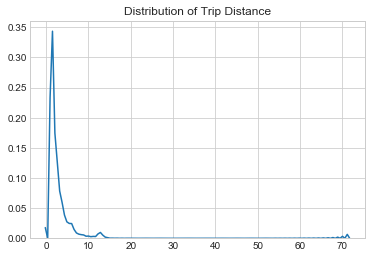

In [181]:
# Graph of trip distances
sns.kdeplot(train['trip_distance'].values).set_title("Distribution of Trip Distance")

#### Log-transform ```trip_distance``` ####

In [182]:
# Log transform trip distance to improve distribution for modeling.
train['log_trip_distance'] = np.log(train.trip_distance)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Distribution of Trip Distance')

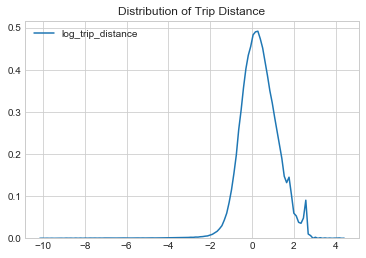

In [183]:
# Graph of trip distances (log scale)
sns.kdeplot(train.log_trip_distance).set_title("Distribution of Trip Distance")

In [184]:
train.trip_distance.describe()

count    2.930636e+06
mean     2.068445e+00
std      2.335536e+00
min      0.000000e+00
25%      7.811311e-01
50%      1.339012e+00
75%      2.430715e+00
max      7.150330e+01
Name: trip_distance, dtype: float64

In [185]:
short_trips = train[train.trip_distance < 0.05]

Text(0.5,1,'trip distance vs. fare amount')

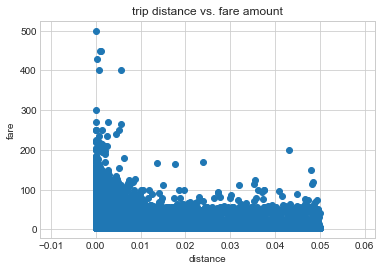

In [186]:
plt.scatter(x = short_trips['trip_distance'], y=short_trips['fare_amount'])
plt.xlabel('distance')
plt.ylabel('fare')
plt.title('trip distance vs. fare amount')

Removing samples with ```trip_distance``` < 0.05 miles. 

In [187]:
train = train[train.trip_distance > 0.05]
train.shape

(2887300, 21)

Text(0.5,1,'Trip distance vs. fare amount')

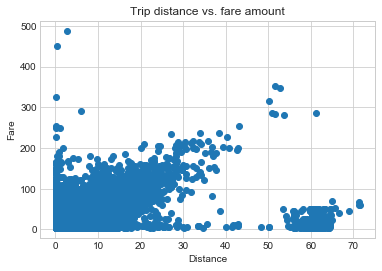

In [188]:
# Plot distances and fares

plt.scatter(x=train['trip_distance'], y=train['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("Fare")
plt.title("Trip distance vs. fare amount")

It looks like there are fixed-rate trips above $50. These may be airport pickups and dropoffs. We will explore this below.

### Airport Trips ###

In [189]:
non_airport_train = train[train.to_from_airport == 0]
airport_train = train[train.to_from_airport == 1]

In [190]:
print(non_airport_train.shape)
print(airport_train.shape)

(2787638, 21)
(99662, 21)


Text(0.5,1,'Trip Distance vs Fare Amount (excluding airport rides)')

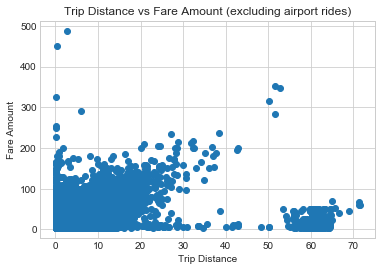

In [191]:
plt.scatter(x=non_airport_train['trip_distance'],y=non_airport_train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

It still looks like we have a concentration of long trips at low fares. We will explore those further here.

In [192]:
long_trips = train[train.trip_distance > 50]
long_trips.shape

(435, 21)

There are only 435 long trips in our training dataset (of 3M samples). 

### Datetime Features ###

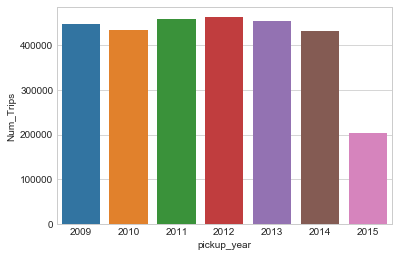

In [193]:
trips_year = train.groupby(['pickup_year'])['key'].count().reset_index().rename(columns = {'key' : 'Num_Trips'})
trips_year.head()
sns.barplot(x = 'pickup_year', y = 'Num_Trips', data = trips_year)

In [137]:
trips_year_fare_amount=train.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

Text(0.5,1,'Avg Fare Amount over Years')

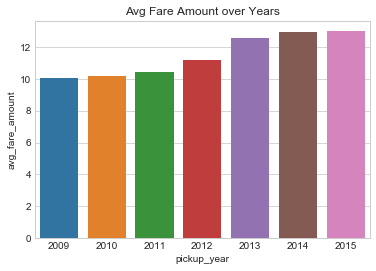

In [138]:
sns.barplot(x='pickup_year',y='avg_fare_amount',data=trips_year_fare_amount).set_title("Avg Fare Amount over Years")

Fare amount has increased as year increases.

In [139]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=train.groupby([groupby_key])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

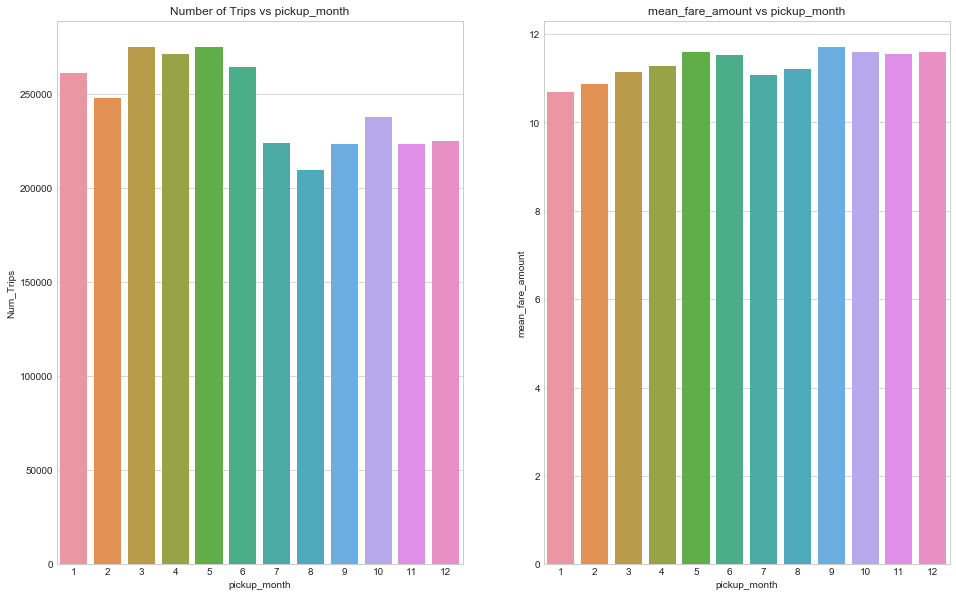

In [140]:
groupandplot(train,'pickup_month','fare_amount')

Fare by month is fairly constant. Less trips in June through December

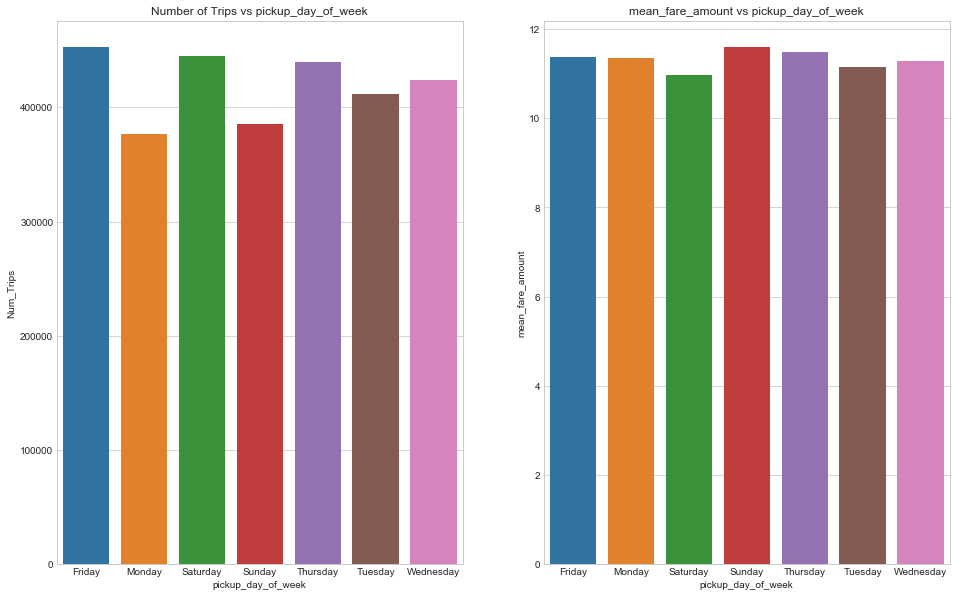

In [142]:
groupandplot(train,'pickup_day_of_week','fare_amount')

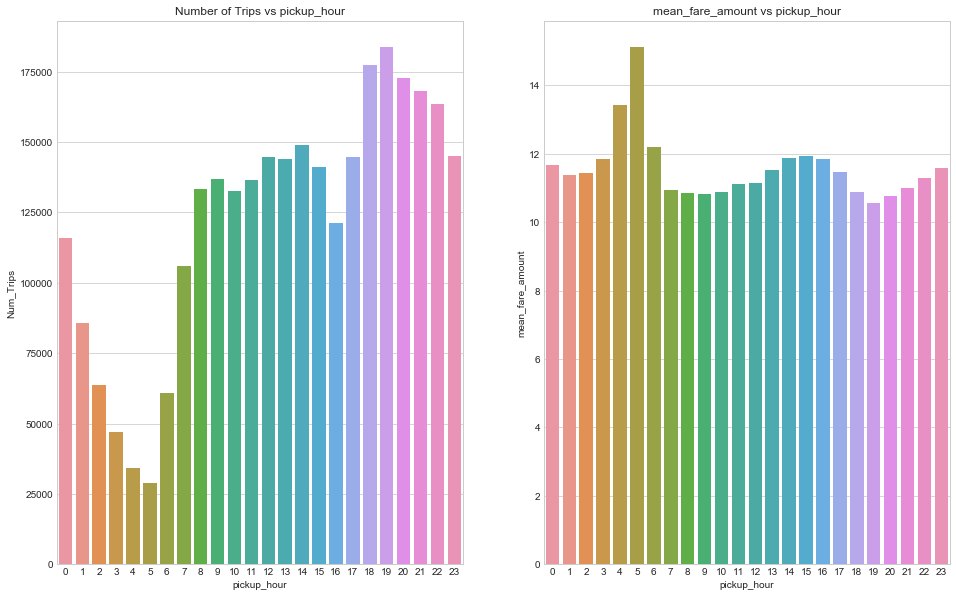

In [143]:
groupandplot(train,'pickup_hour','fare_amount')


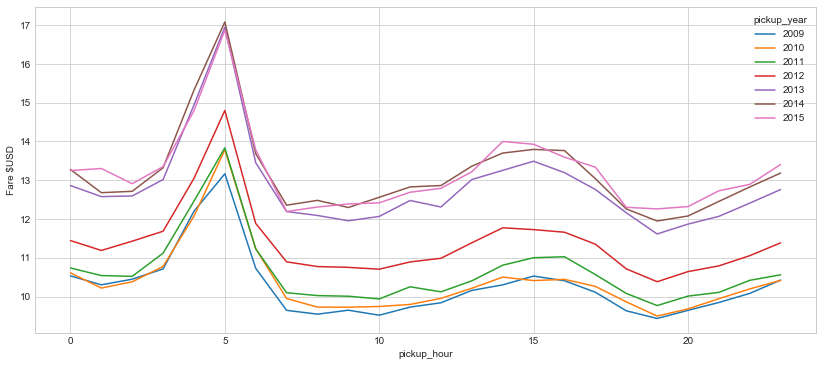

In [145]:
# display pivot table
train.pivot_table('fare_amount', index='pickup_hour', columns='pickup_year').plot(figsize=(14,6))
plt.ylabel('Fare $USD');

Let's add a ```fare_per_mile``` feature.

In [149]:
train.trip_distance.describe()

count    2.935682e+06
mean     2.065553e+00
std      2.335194e+00
min      0.000000e+00
25%      7.789764e-01
50%      1.336989e+00
75%      2.428304e+00
max      7.150330e+01
Name: trip_distance, dtype: float64

In [161]:
train['fare_per_mile'] = train.fare_amount / train.trip_distance
train.fare_per_mile.describe()

count    2.888827e+06
mean     7.422906e+00
std      1.242178e+01
min      2.307277e-03
25%      4.769930e+00
50%      6.134022e+00
75%      8.087379e+00
max      3.812572e+03
Name: fare_per_mile, dtype: float64

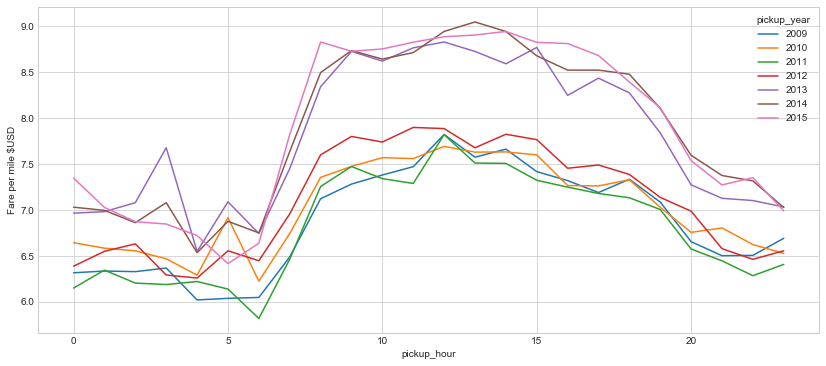

In [163]:
train.pivot_table('fare_per_mile', index='pickup_hour', columns='pickup_year').plot(figsize=(14,6))
plt.ylabel('Fare per mile $USD');

Average fare is highest at and around 5am while the number of trips are lowest during that period. Roughly, the highest fares are when there are the fewest trips, and the lowest fares occur when the frequency of trips is the highest.

Fare per mile is roughly inverse to fare. Low around 5am and high from 10-4pm. 

### Passenger Count ###

In [165]:
train.groupby('passenger_count')['trip_distance', 'fare_amount'].mean()

,trip_distance,fare_amount
passenger_count,,
0,1.775006,8.908069
1,2.071010,11.152171
2,2.206596,11.773897
3,2.133340,11.522552
4,2.168997,11.711604
5,2.107729,11.221355
6,2.140714,12.171898
9,8.106351,104.000000


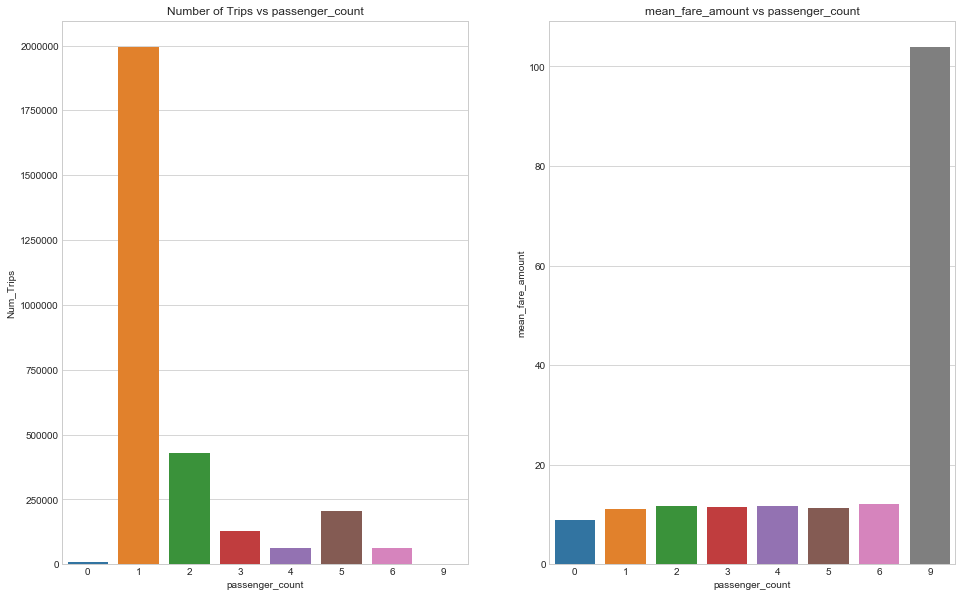

In [167]:
groupandplot(train,'passenger_count','fare_amount')

In [169]:
train[train['passenger_count']>=9].shape

(1, 22)

There is only one entry with 9 or more passengers. We will remove from our dataset data where the number of passengers  > 8.

In [194]:
train = train[train['passenger_count'] <= 8]
train.shape

(2887299, 21)

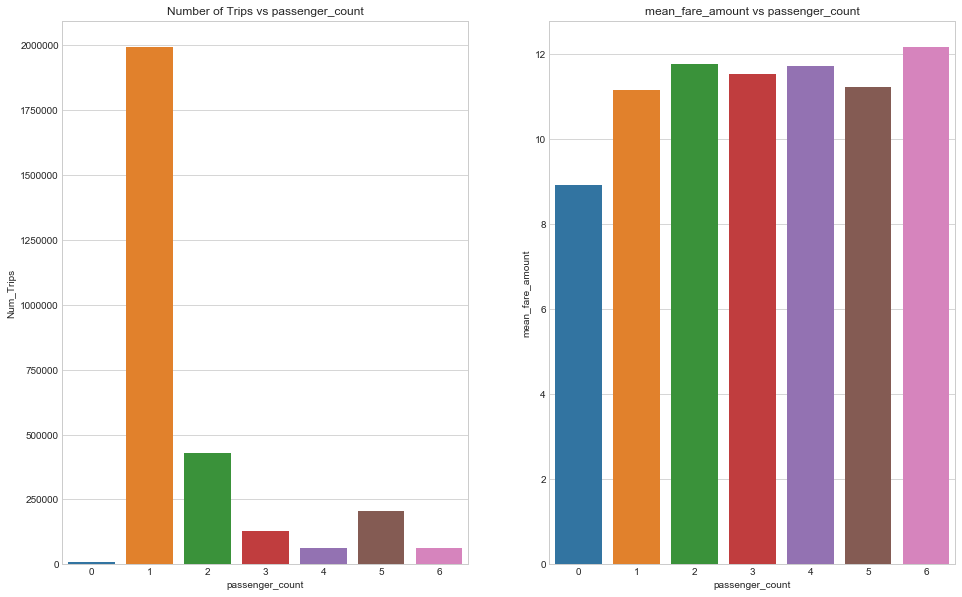

In [195]:
groupandplot(train,'passenger_count','fare_amount')


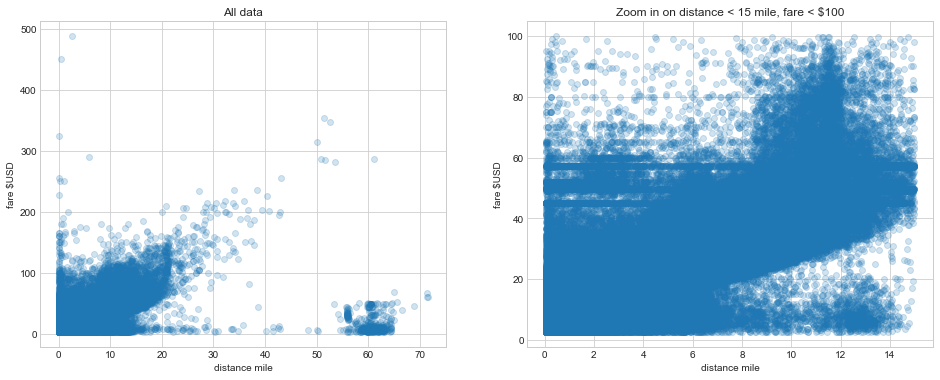

In [198]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(train.trip_distance, train.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (train.trip_distance < 15) & (train.fare_amount < 100)
axs[1].scatter(train[idx].trip_distance, train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 mile, fare < $100');

In [200]:
min(train.fare_amount)

2.5

In [205]:
train.to_csv("train_cleaned.csv", index=False)

## Baseline Model ##

In [51]:
# define dataset
df_train = df_train[df_train.passenger_count != 0]
features = ['year', 'hour', 'distance_miles', 'passenger_count']
X = df_train[features].values
y = df_train['fare_amount'].values

In [52]:
X.shape, y.shape

((1919725, 4), (1919725,))

In [53]:
# error functions
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

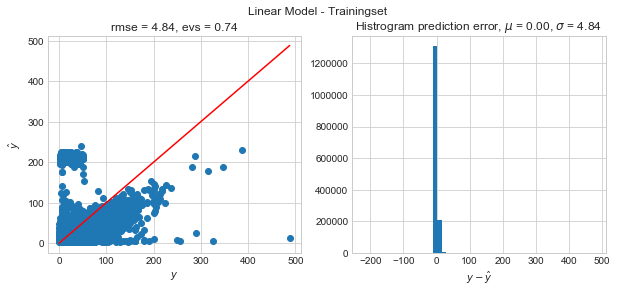

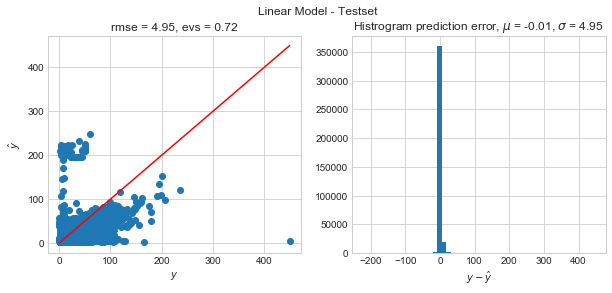

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)

y_train_pred = model_lin.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')